In [ ]:
!nvidia-smi


Tue Mar 28 00:19:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import platform
print(platform.processor())


x86_64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1>Segmentator</h1>

<h2>Prepare dependencies and files</h2>

In [ ]:
pip install pypng

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 2.6 MB/s eta 0:00:00


In [ ]:
cd /content/drive/MyDrive/uois

/content/drive/MyDrive/uois


In [ ]:
pwd

'/content/drive/MyDrive/uois'

In [ ]:
# import dependencies

%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # TODO: Change this if you have more than 1 GPU

import sys
import json
from time import time
import glob

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2

# My libraries. Ugly hack to import from sister directory
import src.data_augmentation as data_augmentation
import src.segmentation as segmentation
import src.evaluation as evaluation
import src.util.utilities as util_
import src.util.flowlib as flowlib

from google.colab.patches import cv2_imshow

<h2>Set Object Segmentation (UOIS) model parameters and get checkpoint</h2>

In [ ]:
# Depth Seeding Network Parameters
dsn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal

    # Mean Shift parameters (for 3D voting)
    'max_GMS_iters' : 10, 
    'epsilon' : 0.05, # Connected Components parameter
    'sigma' : 0.02, # Gaussian bandwidth parameter
    'num_seeds' : 200, # Used for MeanShift, but not BlurringMeanShift
    'subsample_factor' : 5,
    
    # Misc
    'min_pixels_thresh' : 500,
    'tau' : 15.,
    
}

# Region Refinement Network parameters
rrn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal
    'img_H' : 224,
    'img_W' : 224,
    
    # architecture parameters
    'use_coordconv' : False,
    
}

# UOIS-Net-3D Parameters
uois3d_config = {
    
    # Padding for RGB Refinement Network
    'padding_percentage' : 0.25,
    
    # Open/Close Morphology for IMP (Initial Mask Processing) module
    'use_open_close_morphology' : True,
    'open_close_morphology_ksize' : 9,
    
    # Largest Connected Component for IMP module
    'use_largest_connected_component' : True,
    
}

In [ ]:
# prepare net from checkpoint
checkpoint_dir = '/content/drive/MyDrive/uois/model_data/' # TODO: change this to directory of downloaded models
dsn_filename = checkpoint_dir + 'DepthSeedingNetwork_3D_TOD_checkpoint.pth'
rrn_filename = checkpoint_dir + 'RRN_OID_checkpoint.pth'
uois3d_config['final_close_morphology'] = 'TableTop_v5' in rrn_filename
uois_net_3d = segmentation.UOISNet3D(uois3d_config, 
                                     dsn_filename,
                                     dsn_config,
                                     rrn_filename,
                                     rrn_config
                                    )

Let's use 1 GPUs for DSN!
Loaded DSNWrapper model
Let's use 1 GPUs for RRN!
Loaded RRNWrapper model


<h2>Create Functions for image processing</h2>

In [ ]:
def process_rgb(rgb_img):
    """ Process RGB image
            - random color warping
    """
    rgb_img = rgb_img.astype(np.float32)

    rgb_img = data_augmentation.standardize_image(rgb_img)

    return rgb_img

    

def process_depth(depth_img):
    """ Process depth channel
            TODO: CHANGE THIS
            - change from millimeters to meters
            - cast to float32 data type
            - add random noise
            - compute xyz ordered point cloud
    """

    # camera settings 
    camera_config = {'img_width': 640, 'img_height': 480, 'fx': 383.561676025391, 'fy': 383.561676025391, 'x_offset': 318.377197265625, 'y_offset': 238.451675415039}

    # millimeters -> meters
    depth_img = (depth_img / 1000.).astype(np.float32)

    # Compute xyz ordered point cloud    
    xyz_img = util_.compute_xyz(depth_img, camera_config)

    return xyz_img

<h2>Create segmentation function</h2>

In [ ]:
def segmentation_net(depth, color):
    """
        Run segmentation on RGBD image
    """

    # create batch
    # ------------------------------------------------------
    N = 1; # number of images in the testing batch

    # create varibles
    rgb_imgs_RS = np.zeros((N, 480, 640, 3), dtype=np.float32)
    xyz_imgs_RS = np.zeros((N, 480, 640, 3), dtype=np.float32) # ordered point cloud format

    # RGB
    rgb_imgs_RS[0] = process_rgb(color)

    # XYZ - depth
    xyz_imgs_RS[0] = process_depth(depth)

    # build batch from rgb and depth images    
    batch = {
        'rgb' : data_augmentation.array_to_tensor(rgb_imgs_RS), 
        'xyz' : data_augmentation.array_to_tensor(xyz_imgs_RS),
    }


    # run segmentation
    # ------------------------------------------------------
    print('Starting with segmentation')
    ### Compute segmentation masks ###
    st_time = time()
    fg_masks, center_offsets, initial_masks, seg_masks = uois_net_3d.run_on_batch(batch)
    total_time = time() - st_time
    print('Total time taken for Segmentation: {0} seconds'.format(round(total_time, 3)))
    print('FPS: {0}'.format(round(N / total_time,3)))

    # Get results in numpy
    seg_masks = seg_masks.cpu().numpy()
    fg_masks = fg_masks.cpu().numpy()
    center_offsets = center_offsets.cpu().numpy().transpose(0,2,3,1)
    initial_masks = initial_masks.cpu().numpy()

    return seg_masks, fg_masks, center_offsets, initial_masks

<h2>Create function that loads all images into program</h2>

In [ ]:
def read_image_pairs(folder_path):
    image_array = []
    for file_name in os.listdir(folder_path):
        if file_name.startswith("depth_"):
            # Check if there is a corresponding color image
            color_file_name = "color_" + file_name[6:]
            color_file_path = os.path.join(folder_path, color_file_name)
            if os.path.exists(color_file_path):
                # Read depth and color images and store them in the array
                depth_file_path = os.path.join(folder_path, file_name)
                # depth_image = limit_depth(cv2.imread(depth_file_path, cv2.IMREAD_UNCHANGED), 200, 1500) # depth from 20cm to 1.5m 
                depth_image = cv2.imread(depth_file_path, cv2.IMREAD_UNCHANGED)
                color_image = cv2.imread(color_file_path)
                # Convert BGR to RGB
                rgb_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
                image_array.append((depth_image, rgb_image))
    return image_array

In [ ]:
def display_image_pair(image_array, index):
    depth_image, color_image = image_array[index]
    # Normalize depth image
    depth_image = cv2.normalize(depth_image, None, 0, 255, cv2.NORM_MINMAX)
    depth_image = depth_image.astype('uint8')
    print("Depth Image:")
    # cv2_imshow(depth_image)
    plt.imshow(depth_image)
    plt.show()
    print("Color Image:")
    # cv2_imshow(color_image)
    plt.imshow(color_image)
    plt.show()

<h2>Run UOIS Example</h2>

In [ ]:
folder_path = '/content/drive/MyDrive/uois/objects_1/'

# load images
all_images = read_image_pairs(folder_path)


Depth Image:


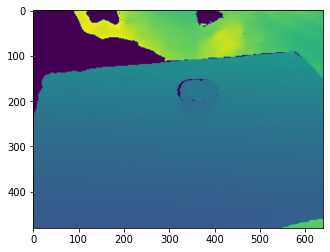

Color Image:


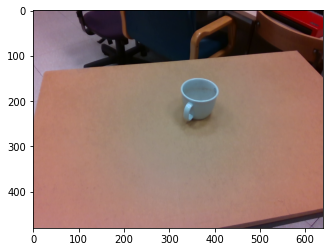

In [ ]:
display_image_pair(all_images, 10)

Starting with segmentation


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4014: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Total time taken for Segmentation: 6.925 seconds
FPS: 0.144


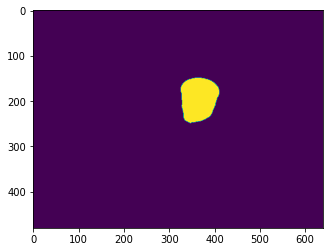

In [ ]:
# load one image pair
depth_image, color_image = all_images[10]

seg_masks, fg_masks, center_offsets, initial_masks = segmentation_net(depth_image, color_image)

plt.imshow(seg_masks[0,:,:])
plt.show()

In [ ]:
# plt.imshow(seg_masks[0,:,:])
# plt.show()

<h2>Create a function that cuts out of RGB image every object for classification </h2>

In [ ]:
def get_objects(color_image, seg_masks):

    # get unique values in the array
    unique_values = np.unique(seg_masks)

    plt.figure()

    # Convert the mask to a binary mask
    binary_mask = (seg_masks[0,:,:] > 0)

    # Create an array of zeros with the same shape as the RGB image
    full_overlay = np.zeros(color_image.shape, dtype=np.uint8)

    # Copy the RGB image to the overlay array where the binary mask is True
    full_overlay[binary_mask] = color_image[binary_mask]

    # plt.imshow(full_overlay)
    # plt.show()

    images = [] # create an empty list to store the images
    boxes = [] # create an empty list 


    # print the unique values
    for val in (unique_values):
        # print(val)
        # plt.figure()
        arr = seg_masks[0,:,:] == val


        # find the index of the first non-zero column
        first_nonzero_col = np.nonzero(np.any(arr, axis=0))[0][0]

        # find the index of the last non-zero column
        last_nonzero_col = np.nonzero(np.any(arr, axis=0))[0][-1]

        # find the index of the first non-zero row
        first_nonzero_row = np.nonzero(np.any(arr, axis=1))[0][0]

        # find the index of the last non-zero row
        last_nonzero_row = np.nonzero(np.any(arr, axis=1))[0][-1]

        # print the results
        # print("First non-zero column index:", first_nonzero_col)
        # print("Last non-zero column index:", last_nonzero_col)
        # print("First non-zero row index:", first_nonzero_row)
        # print("Last non-zero row index:", last_nonzero_row)

        if np.absolute(last_nonzero_col-first_nonzero_col) > 50 and np.absolute(last_nonzero_row-first_nonzero_row) > 50 and val > 0:
            # cut out

            padding0 = 20

            if (color_image.shape[0]-last_nonzero_row > padding0 and first_nonzero_row > padding0 and first_nonzero_col > padding0 and color_image.shape[1]-last_nonzero_col > padding0):
                padding = 20
            else:
                padding = 0

            # print("pading: " + str(padding))    

            cut_image = color_image[first_nonzero_row-padding:last_nonzero_row+padding, first_nonzero_col-padding:last_nonzero_col+padding]

            images.append(cut_image) # append each cut_image to the images list

            boxes.append([first_nonzero_row-padding, first_nonzero_col-padding, last_nonzero_row+padding, last_nonzero_col+padding]) # append each bounding box to the boxes list

            cut_overlay = full_overlay[first_nonzero_row-padding:last_nonzero_row+padding, first_nonzero_col-padding:last_nonzero_col+padding]

    # Create a copy of the original image
    img_copy = color_image.copy()
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)


    # Draw bounding boxes
    for box in boxes:
        cv2.rectangle(img_copy, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)  

        cut_image = color_image[box[0]:box[2], box[1]:box[3]]
        id, label = classifier(cut_image)

        # For the text background
        # Finds space required by the text so that we can put a background with that amount of width.
        # (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        # Prints the text.
        # img_copy = cv2.rectangle(img_copy, (box[0], box[1] - 20), (box[1] + w, box[0]), (255,0,0), -1)
        img_copy = cv2.putText(img_copy, label, (box[1] + 5, box[0] - 7), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

    # show cut image
    plt.imshow(img_copy)
    plt.show()

    return images, img_copy, boxes

In [ ]:
# boxes = []
# cutouts, marked_image, boxes = get_objects(color_image, seg_masks)

<h1> Classification </h1>

<h2>Imports</h2>

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

<h2> Prepare the model </h2>

In [ ]:
# Load the pre-trained model
model = models.resnet152()

# Modify the first layer to accept 32x32 input images
# model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# model.maxpool = torch.nn.Identity()

num_classes = 8 # "banana", "bottle", "bowl", "box", "cup", "orange", "other", "wallet"
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Load the model weights
model.load_state_dict(torch.load('/content/drive/MyDrive/uois/resnet/model_weights_resnet_152_imagenet.pth'))

<All keys matched successfully>

<h2>Prepare the classification function </h2>

In [ ]:
# Define a function to return object label
def get_label(number):
    labels = ["banana", "bottle", "bowl", "box", "cup", "orange", "other", "wallet"]
    if number < 0 or number >= len(labels):
        return "Invalid input"
    else:
        return labels[number]

In [ ]:
def classifier (image):

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(image.astype('uint8')).convert('RGB')

    # Define the image transformations
    transform = transforms.Compose([
    transforms.Resize(200),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
      )
    ])

    # Preprocess the image
    image_tensor = transform(image)
    image_tensor = torch.unsqueeze(image_tensor, 0)

    # Run inference on the model
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    # Print the predicted class
    # print("Predicted class:", predicted.item())
    # print("Predicted label:", get_label(predicted.item()))

    return predicted.item(), get_label(predicted.item())

In [ ]:
# i = 0

# classifier(cutouts[i])

# # # show cut image
# plt.imshow(cutouts[i])
# plt.show()

# Tests

In [ ]:
from google.colab.patches import cv2_imshow

# def display_grid_of_images(images):
#     # Resize the images
#     resized_images = []
#     for img in images:
#         resized_images.append(cv2.resize(img, (240, 320)))

#     # Create a grid of images
#     grid = np.concatenate((np.concatenate((resized_images[0], resized_images[1]), axis=1), np.concatenate((resized_images[2], resized_images[3]), axis=1)), axis=0)

#     # Display the grid
#     cv2_imshow(grid)

def display_grid_of_images(images):
    # Resize the images
    resized_images = []
    for img in images:
        resized_images.append(cv2.resize(img, (240, 320)))

    # Create a grid of images
    num_images = len(resized_images)
    num_rows = int(np.ceil(num_images/4))
    num_cols = 4
    grid = np.zeros((num_rows*320, num_cols*240, 3), dtype=np.uint8)
    for i in range(num_images):
        row = i // num_cols
        col = i % num_cols
        grid[row*320:(row+1)*320, col*240:(col+1)*240] = resized_images[i]

    # Display the grid
    cv2_imshow(grid)


'Num. of images: 11'

Starting with segmentation


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4014: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Total time taken for Segmentation: 0.508 seconds
FPS: 1.969
Predicted class: 6
Predicted label: other
Predicted class: 0
Predicted label: banana
Predicted class: 3
Predicted label: box
Predicted class: 4
Predicted label: cup
Predicted class: 2
Predicted label: bowl
Predicted class: 5
Predicted label: orange


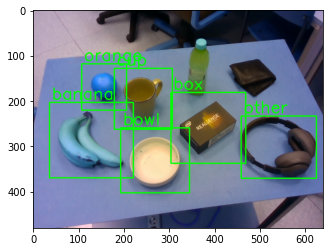

Predicted class: 6
Predicted label: other
Predicted class: 0
Predicted label: banana
Predicted class: 3
Predicted label: box
Predicted class: 4
Predicted label: cup
Predicted class: 2
Predicted label: bowl
Predicted class: 5
Predicted label: orange


NameError: ignored

In [ ]:
folder_path = '/content/drive/MyDrive/uois/class_test/'

# load images
all_images = read_image_pairs(folder_path)


def get_results(images):

    num_images = len(images)
    display("Num. of images: " + str(num_images))

    annotated_images = []
    total_time_segm = 0
    total_time_classif = 0
    
    for i in range(num_images):

        # get pair of images RGB & D
        depth_image, color_image = images[i]

        # measure execution time
        start_time = time()

        # run segmentation
        seg_masks, fg_masks, center_offsets, initial_masks = segmentation_net(depth_image, color_image)

        # measure execution time
        end_time = time()
        total_time_segm += end_time - start_time

        # draw bounding boxes
        cutouts, marked_image, boxes = get_objects(color_image, seg_masks)

       # measure execution time
        start_time = time()
        # classify every cutout
        for image in cutouts:
            class_id, label = classifier(image)
            


        # measure execution time
        end_time = time()
        total_time_classif += end_time - start_time


        # save annotated image to array
        annotated_images.append(marked_image)

        cv2_imshow(grid)

        # print line
        print("\n------------------------------\n")



    # display grid of images
    display_grid_of_images(annotated_images)

    # calculate average execution time
    avg_time_segm = total_time_segm / num_images
    avg_time_classif = total_time_classif / num_images
    
    
    print("\n------------------------------\n------------------------------")

    print("Average execution time for segmentation_net: ", avg_time_segm)
    print("Average execution time for classification: ", avg_time_classif)
    print("Average total time: ", avg_time_segm + avg_time_classif)

    print("\n------------------------------\n------------------------------")
    
get_results(all_images)

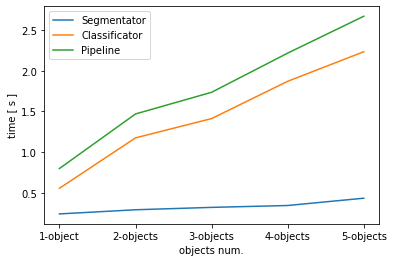

In [ ]:
table = {
    'Num.': ['1-object', '2-objects', '3-objects', '4-objects', '5-objects'],
    'Segmentator': [0.24266369202557733, 0.2936240109530362, 0.3228763103485107, 0.345940215247018, 0.43565045084272114],
    'Classificator': [0.5571772070492015, 1.176292289387096, 1.4130106210708617, 1.8708279473440987, 2.2337029661451067],
    'Pipeline': [0.7998408990747788, 1.469916300340132, 1.7358869314193726, 2.2167681625911166, 2.669353416987828]
}

import matplotlib.pyplot as plt

def plot_table(table):
    for column_name in table:
        if column_name != 'Num.':
            plt.plot(table['Num.'], table[column_name], label=column_name)
    plt.xlabel('objects num.')
    plt.ylabel('time [ s ]')
    plt.legend()
    plt.savefig('time_plot.png')
    plt.show()

plot_table(table)

In [ ]:
cd ./v2

/content/drive/MyDrive/uois/v2


In [ ]:
!unzip /content/drive/MyDrive/Images_ImageNet_and_Scrapper_Resized_Split.zip

In [ ]:
from tqdm import tqdm

def enumerate_subfolders_and_files(directory_path):
    ground_truth = []
    detected_value = []
    for root, dirs, files in os.walk(directory_path):
        for dir in (dirs):
            dir_path = os.path.join(root, dir)
            for file in tqdm(os.listdir(dir_path)):
                file_path = os.path.join(dir_path, file)
                img = cv2.imread(file_path)
                id, label = classifier(img)
                detected_value.append(label)
                ground_truth.append(dir)
                # print('Label: ', dir, '   Detected: ',label)
    return ground_truth, detected_value
ground_truth, detected_value = enumerate_subfolders_and_files('/content/v2/Images_ImageNet_and_Scrapper_Resized_Split/test')   

100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ground_truth, detected_value)

In [ ]:
pwd

'/content/drive/MyDrive/uois/v2'

Confusion matrix, without normalization
[[ 57  13   2   0   0   0   4   0]
 [  0  76   1   0   0   1   1   1]
 [  0   0  67   0   5   0   1   0]
 [  0   0   0  47   0   0   0   3]
 [  0   4   7   0  74   0   0   0]
 [  4  13   7   0   0  42  10   0]
 [  0   0   0   0   0   0 111   0]
 [  0   0   0   1   0   0   1  56]]


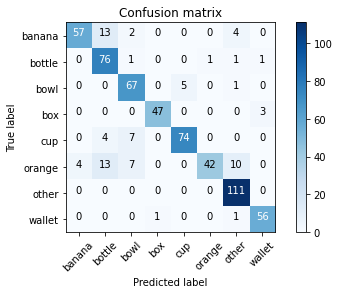

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


labels = ["banana", "bottle", "bowl", "box", "cup", "orange", "other", "wallet"]

plot_confusion_matrix(cm, labels)

Normalized confusion matrix
[[0.75       0.17105263 0.02631579 0.         0.         0.
  0.05263158 0.        ]
 [0.         0.95       0.0125     0.         0.         0.0125
  0.0125     0.0125    ]
 [0.         0.         0.91780822 0.         0.06849315 0.
  0.01369863 0.        ]
 [0.         0.         0.         0.94       0.         0.
  0.         0.06      ]
 [0.         0.04705882 0.08235294 0.         0.87058824 0.
  0.         0.        ]
 [0.05263158 0.17105263 0.09210526 0.         0.         0.55263158
  0.13157895 0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.        ]
 [0.         0.         0.         0.01724138 0.         0.
  0.01724138 0.96551724]]


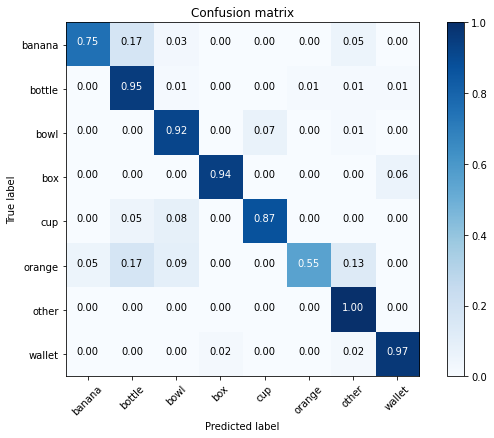

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(8, 6)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=figsize)  # adjust figure size
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()  # display the plot

plot_confusion_matrix(cm, labels)

In [ ]:
def calculate_metrics(ground_truth, detected):
    """
    Calculates TP, FP, TN and FN for every class.

    Args:
    ground_truth (list): List of ground truth classes.
    detected (list): List of detected classes.

    Returns:
    dict: A dictionary containing TP, FP, TN and FN for every class.
    """
    metrics = {}
    for i in range(len(ground_truth)):
        if ground_truth[i] == detected[i]:
            if ground_truth[i] not in metrics:
                metrics[ground_truth[i]] = {'TP': 1, 'FP': 0, 'TN': 0, 'FN': 0}
            else:
                metrics[ground_truth[i]]['TP'] += 1
        else:
            if ground_truth[i] not in metrics:
                metrics[ground_truth[i]] = {'TP': 0, 'FP': 1, 'TN': 0, 'FN': 0}
            else:
                metrics[ground_truth[i]]['FP'] += 1
            if detected[i] not in metrics:
                metrics[detected[i]] = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 1}
            else:
                metrics[detected[i]]['FN'] += 1
        for key in metrics.keys():
            if key != ground_truth[i] and key != detected[i]:
                if key not in metrics:
                    metrics[key] = {'TP': 0, 'FP': 0, 'TN': 1, 'FN': 0}
                else:
                    metrics[key]['TN'] += 1
    return metrics

metrics = calculate_metrics(ground_truth, detected_value)

In [ ]:
def calculate_metrics(metrics):
    result = {}
    for key, value in metrics.items():
        TP = value['TP']
        FP = value['FP']
        TN = value['TN']
        FN = value['FN']
        
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        accuracy = (TP + TN) / (TP + FP + TN + FN)
        f1_score = 2 * precision * recall / (precision + recall)
        
        result[key] = {'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1_score': f1_score}
        
    return result

metrics_results = calculate_metrics(metrics)
print(metrics_results)

{'bowl': {'precision': 0.9178082191780822, 'recall': 0.7976190476190477, 'accuracy': 0.9622331691297209, 'f1_score': 0.8535031847133758}, 'cup': {'precision': 0.8705882352941177, 'recall': 0.9367088607594937, 'accuracy': 0.9737274220032841, 'f1_score': 0.9024390243902438}, 'other': {'precision': 1.0, 'recall': 0.8671875, 'accuracy': 0.9706390328151986, 'f1_score': 0.9288702928870293}, 'wallet': {'precision': 0.9655172413793104, 'recall': 0.9333333333333333, 'accuracy': 0.9888059701492538, 'f1_score': 0.9491525423728815}, 'box': {'precision': 0.94, 'recall': 0.9791666666666666, 'accuracy': 0.9921104536489151, 'f1_score': 0.9591836734693877}, 'banana': {'precision': 0.75, 'recall': 0.9344262295081968, 'accuracy': 0.9462616822429907, 'f1_score': 0.832116788321168}, 'bottle': {'precision': 0.95, 'recall': 0.7169811320754716, 'accuracy': 0.9203747072599532, 'f1_score': 0.8172043010752688}, 'orange': {'precision': 0.5526315789473685, 'recall': 0.9767441860465116, 'accuracy': 0.90056818181818